In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def creategrid(size):
    grid = np.zeros((size, size, size))  
    print(grid.shape)
    return grid

In [3]:
def circle(radius, z_position, grid,voltage):
    if radius > grid[0].size:
        print("Radius of grid too big")
        return grid
    else:
        centerpoint = round(int(grid[2].shape[0])/ 2)
        for x in range(grid.shape[0]):
            for y in range(grid.shape[1]):
                if(x - centerpoint)**2+(y-centerpoint)**2 <= radius**2:
                    grid[x,y,z_position] = voltage
    return grid

In [4]:
def drawgridslice(grid,zvalue,axis):
    match axis:
        case 'x':
            slice_z = grid[zvalue,:,:]
        case 'y':
            slice_z = grid[:,zvalue,:]
        case 'z':
            slice_z = grid[:,:,zvalue]
    centerpoint = round(int(grid[2].shape[0])/ 2)
    plt.figure(figsize=(6, 6))
    plt.imshow(slice_z, cmap="viridis")  # 'viridis' is a color map; you can use others like 'hot', 'plasma', etc.
    plt.colorbar(label='Value')
    plt.title("2D Slice of 3D Grid at z="+str(zvalue))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.text(centerpoint, centerpoint, f'{grid[centerpoint,centerpoint,zvalue]:.2f}', color='white', ha='center', va='center',
             bbox=dict(facecolor='black', edgecolor='none', pad=1.5))
# Highlight the point with a marker
    plt.plot(centerpoint, centerpoint, 'ro')  # Red dot at the point (y, x)
    plt.show()

(102, 102, 102)


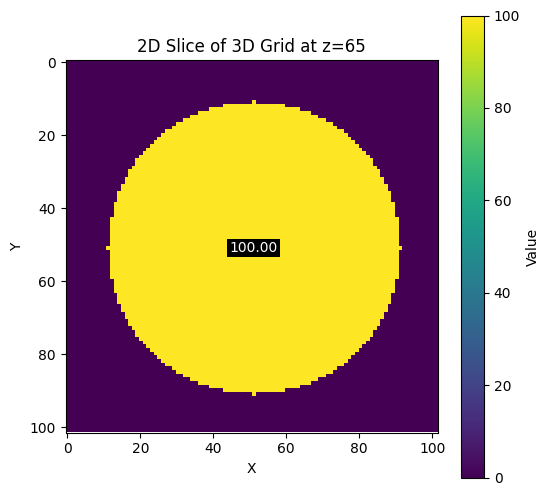

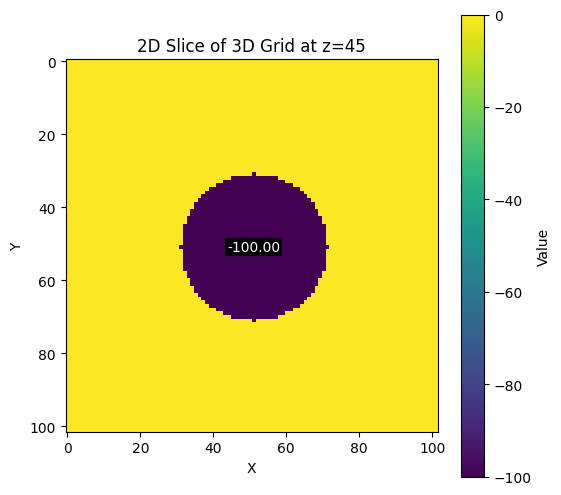

In [5]:
mygrid = creategrid(102)

mygrid = circle(40,65,mygrid,100.0) #circle #1
mygrid = circle(20,45,mygrid,-100.0) #circle #2



drawgridslice(mygrid,65,'z')
drawgridslice(mygrid,45,'z')

In [6]:
def draw3dgrid(grid):
    x,y,z = np.nonzero(grid)
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='.')
    # Labels and color bar
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.colorbar(scatter, ax=ax, label='Height (z-value)')
    
    plt.title("3D Plot of Non-zero Points in the Grid")
    plt.show()

def myrelaxationsolver(grid,iterations):
   gridboundaries = grid.copy()
   gridtemp = grid.copy()
   gridold = grid.copy()
   for l in tqdm(range(iterations)):
       incrementor = 1 #int((iterations-iterations/2)/((l+1)))
       for i in range(grid.shape[0]):
           for j in range(grid.shape[0]):
               for k in range(grid.shape[0]):
                   try:
                       gridtemp[i,j,k] =(gridold[i+incrementor,j,k]+gridold[i-incrementor,j,k]+gridold[i,j+incrementor,k]+gridold[i,j-incrementor,k]+gridold[i,j,k+incrementor]+gridold[i,j,k-incrementor])/6
                   except IndexError:
                       pass
       gridtemp = np.where(gridboundaries !=0, gridboundaries,gridtemp)
       gridold = gridtemp.copy()
   return gridtemp

def relaxationsolver(grid, iterations):
    # Create a padded version of the grid to handle boundary conditions more efficiently
    padded_grid = np.pad(grid, pad_width=1, mode='constant', constant_values=0)
    gridboundaries = np.pad(grid.copy(), pad_width=1, mode='constant', constant_values=0)

    for _ in tqdm(range(iterations)):
        # Use array slicing to get neighboring cells without for loops
        grid_temp = (padded_grid[2:, 1:-1, 1:-1] + padded_grid[:-2, 1:-1, 1:-1] +
                     padded_grid[1:-1, 2:, 1:-1] + padded_grid[1:-1, :-2, 1:-1] +
                     padded_grid[1:-1, 1:-1, 2:] + padded_grid[1:-1, 1:-1, :-2]) / 6

        # Ensure boundaries are preserved by overwriting them back from `gridboundaries`
        np.copyto(grid_temp, gridboundaries[1:-1, 1:-1, 1:-1], where=(gridboundaries[1:-1, 1:-1, 1:-1] != 0))

        # Update the padded grid for the next iteration
        padded_grid[1:-1, 1:-1, 1:-1] = grid_temp

    # Return the final result without padding
    return padded_grid[1:-1, 1:-1, 1:-1]


In [7]:
def relaxationsolver_GPU(grid, iterations):
    """
    Relaxed solver method using GPU.

    Args:
    grid (numpy.ndarray): Input grid.
    iterations (int): Number of iterations.

    Returns:
    numpy.ndarray: Relaxed grid solution.
    """

    # Move grid to GPU
    grid_gpu = cp.asarray(grid)

    # Create a padded version of the grid to handle boundary conditions more efficiently
    # This means, essentially adding another "shell" of empty values which = 0". So when I shift around, I don't run out of space?
    padded_grid_gpu = cp.pad(grid_gpu, pad_width=1, mode='constant', constant_values=0)
    gridboundaries_gpu = cp.pad(grid_gpu.copy(), pad_width=1, mode='constant', constant_values=0)

    for _ in tqdm(range(iterations)):
        # Use array slicing to get neighboring cells without for loops
        grid_temp_gpu = (padded_grid_gpu[2:, 1:-1, 1:-1] + padded_grid_gpu[:-2, 1:-1, 1:-1] +
                         padded_grid_gpu[1:-1, 2:, 1:-1] + padded_grid_gpu[1:-1, :-2, 1:-1] +
                         padded_grid_gpu[1:-1, 1:-1, 2:] + padded_grid_gpu[1:-1, 1:-1, :-2]) / 6

        # Ensure boundaries are preserved by overwriting them back from `gridboundaries`
        cp.copyto(grid_temp_gpu, gridboundaries_gpu[1:-1, 1:-1, 1:-1], where=(gridboundaries_gpu[1:-1, 1:-1, 1:-1] != 0))

        # Update the padded grid for the next iteration
        padded_grid_gpu[1:-1, 1:-1, 1:-1] = grid_temp_gpu

    # Return the final result without padding and move back to CPU
    return padded_grid_gpu[1:-1, 1:-1, 1:-1].get()

In [8]:
mylist = np.array([0,1.0,2.0,3.0,4.0,5.0,0])
for i in range(10):
    #print(mylist[1:-1])
    #print(mylist[2:])
    #print(mylist[:-2])
    mylist[1:-1] = (mylist[1:-1]+mylist[2:]+mylist[:-2])/3
    mylist[3] = 3
    print(np.round(mylist))

[0. 1. 2. 3. 4. 3. 0.]
[0. 1. 2. 3. 3. 2. 0.]
[0. 1. 2. 3. 3. 2. 0.]
[0. 1. 2. 3. 3. 2. 0.]
[0. 1. 2. 3. 2. 1. 0.]
[0. 1. 2. 3. 2. 1. 0.]
[0. 1. 2. 3. 2. 1. 0.]
[0. 1. 2. 3. 2. 1. 0.]
[0. 1. 2. 3. 2. 1. 0.]
[0. 1. 2. 3. 2. 1. 0.]


In [9]:
solvedgrid_0 = myrelaxationsolver(mygrid,50)
sovledgrid = relaxationsolver(mygrid,1000)
sovledgrid2 = relaxationsolver_GPU(mygrid,10000)

100%|██████████| 10000/10000 [00:02<00:00, 3360.09it/s]


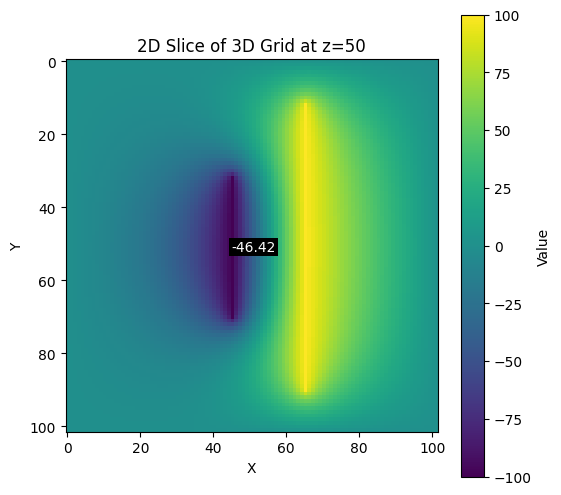

In [10]:
#drawgridslice(sovledgrid,50,'x')
drawgridslice(sovledgrid2,50,'x')


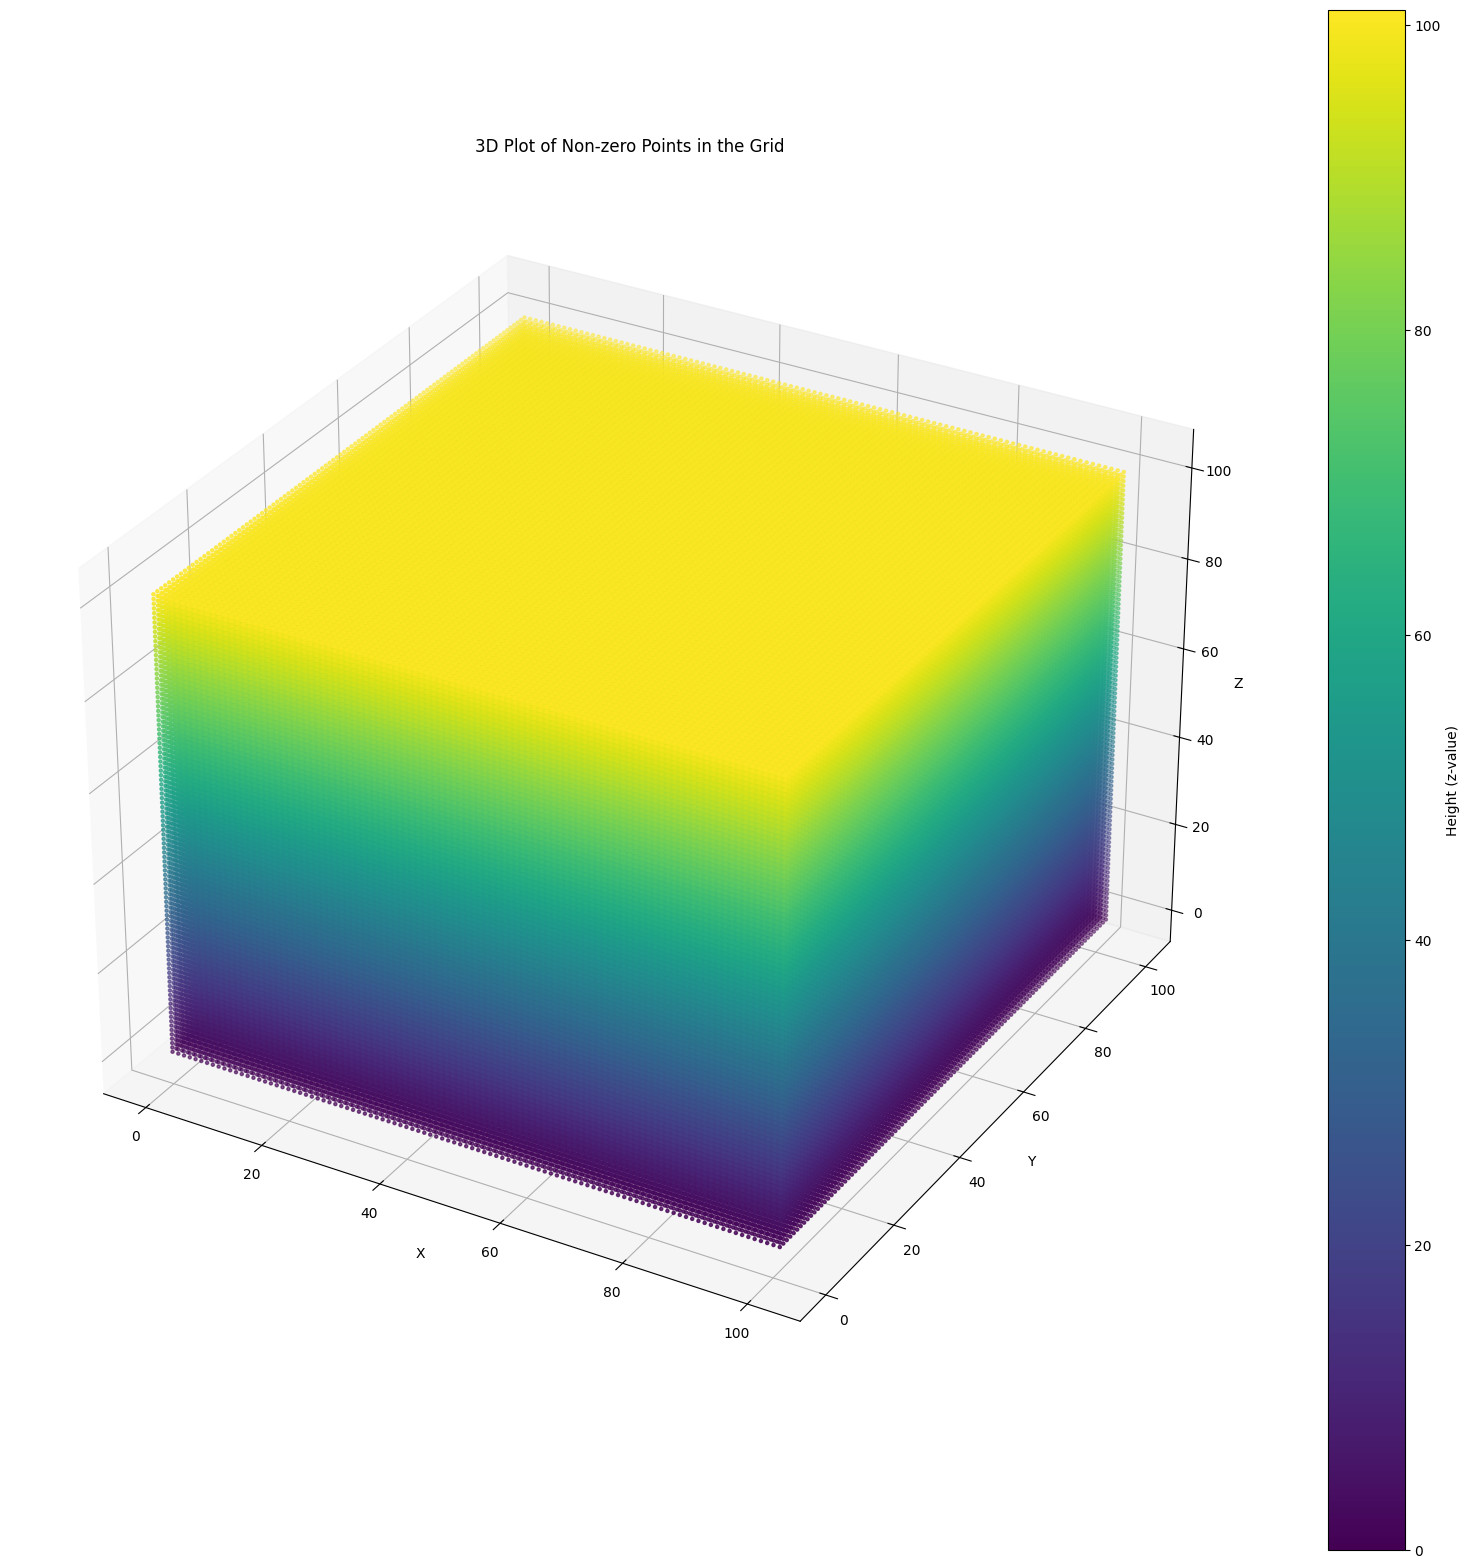

In [11]:
draw3dgrid(sovledgrid)

In [12]:
electric_field_x,electric_field_y,electric_field_z = np.gradient(-1*sovledgrid2)
electric_field = np.stack((electric_field_x,electric_field_y,electric_field_z), axis = -1)

In [13]:
def drawgridslice_vector(xvalue,grad_y,grad_z):
    # Extract the gradients in the y and z directions at xvalue
    slice_grad_y = grad_y[xvalue, :, :]
    slice_grad_z = grad_z[xvalue, :, :]
    
    # Generate coordinate grids for the plot (y, z coordinates)
    y = np.arange(slice_grad_y.shape[0])  # Number of rows (y-direction)
    z = np.arange(slice_grad_y.shape[1])  # Number of columns (z-direction)
    Y, Z = np.meshgrid(y, z)
    # Keep every 5th point in each direction
    step = 5  # Keep every 5th point
    Y_sub = Y[::step, ::step]
    Z_sub = Z[::step, ::step]
    slice_grad_y_sub = slice_grad_y[::step, ::step]
    slice_grad_z_sub = slice_grad_z[::step, ::step]
    #log_arr_y = np.sign(slice_grad_y) * np.log(np.abs(slice_grad_y))
    #log_arr_z = np.sign(slice_grad_z) * np.log(np.abs(slice_grad_z))

    magnitude = np.sqrt(slice_grad_y**2 + slice_grad_z**2)    # Plot the quiver plot with larger arrows
    plt.figure(figsize=(20, 20))
    plt.quiver(Z, Y,slice_grad_y/1,slice_grad_z/1, magnitude,cmap = 'viridis')
    plt.colorbar(label='Magnitude')
    plt.xlabel("Y")
    plt.ylabel("Z")
    plt.show()

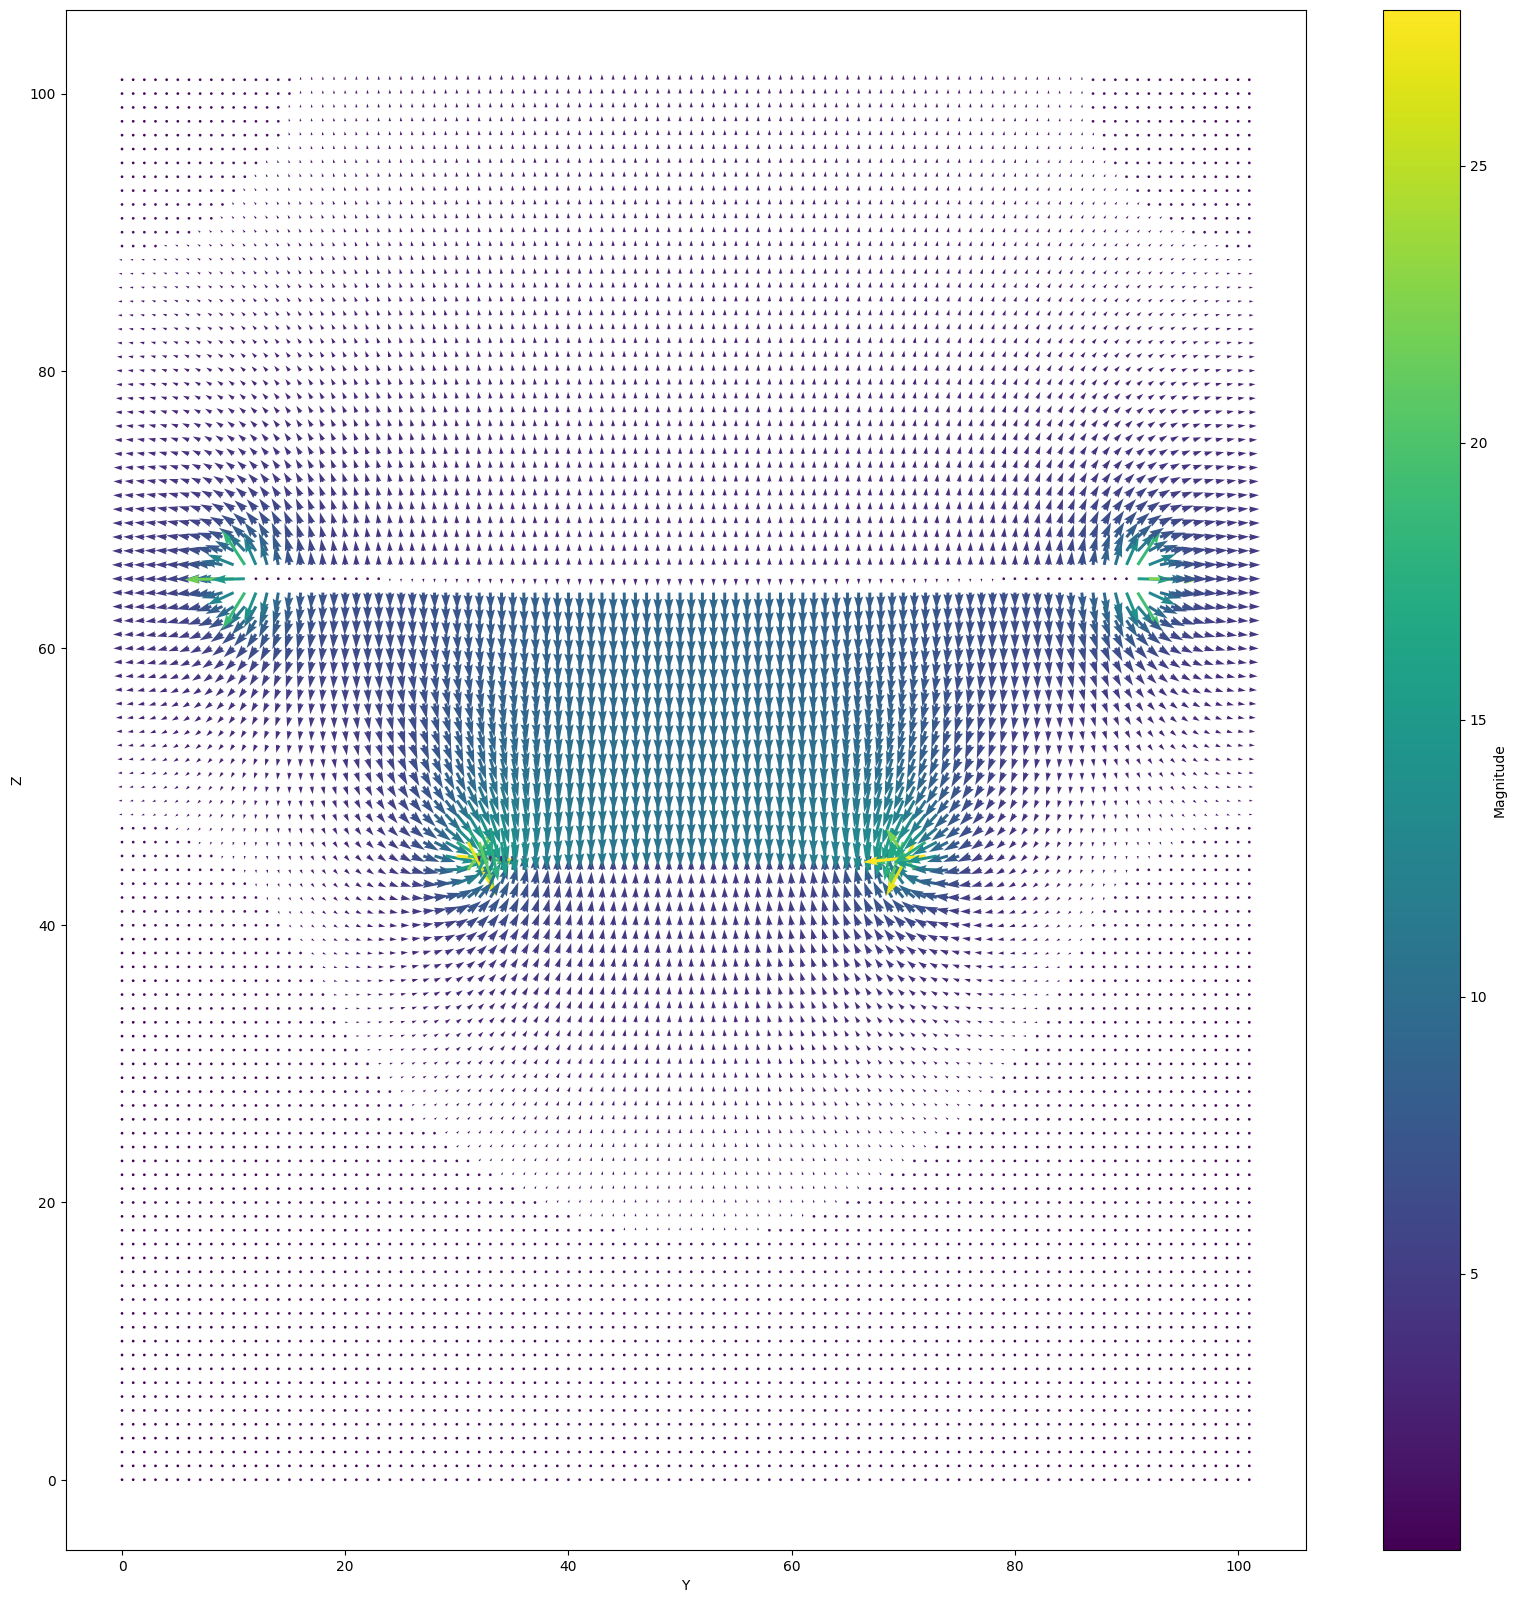

In [14]:
drawgridslice_vector(51,electric_field_y,electric_field_z)

In [15]:
def visualize_vector_field(vector_field, title="Vector Field"):
    """
    Visualize a 3D vector field.
    
    Parameters:
    vector_field (numpy array): (NXNXNX3) matrix representing the vector field.
    title (str): Title of the plot.
    """
    N = vector_field.shape[0]/10
    step = 10
    x, y, z = np.meshgrid(np.arange(N), np.arange(N), np.arange(N), indexing='ij')
    
    u, v, w = vector_field[::step, ::step, ::step, 0], vector_field[::step, ::step, ::step, 1], vector_field[::step, ::step, ::step, 2]
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot vector field
    ax.quiver(x.flatten(), y.flatten(), z.flatten(),
              u.flatten(), v.flatten(), w.flatten(),
              length=0.5, color='blue', alpha=0.7)
    
    # Set plot properties
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

In [16]:
print(electric_field.shape)
%matplotlib notebook
visualize_vector_field(electric_field)

(102, 102, 102, 3)


<IPython.core.display.Javascript object>